In [1]:
import numpy as np
import tensorflow as tf

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2023-08-23 12:11:29.648098: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-08-23 12:11:29.648138: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from maddeb.FlowVAEnet import FlowVAEnet
from maddeb.utils import listdir_fullpath
import seaborn as sns

In [3]:
linear_norm_coeff = 10000
batch_size=50

## Load images

In [4]:
######## List of data samples
from maddeb.dataset_generator import batched_CATSIMDataset

# Define the generators
ds_isolated_train, ds_isolated_val = batched_CATSIMDataset(
    tf_dataset_dir='/sps/lsst/users/bbiswas/simulations/CATSIM_tfDataset/isolated_tfDataset',
    linear_norm_coeff=linear_norm_coeff,
    batch_size=batch_size,
    x_col_name="blended_gal_stamps",
    y_col_name="isolated_gal_stamps",
)
ds_isolated_val = ds_isolated_val.as_numpy_iterator()

You use TensorFlow DType <dtype: 'float32'> in tfds.features This will soon be deprecated in favor of NumPy DTypes. In the meantime it was converted to float32.
Load dataset info from /sps/lsst/users/bbiswas/simulations/CATSIM_tfDataset/isolated_tfDataset/catsim_dataset/1.0.0
Reusing dataset catsim_dataset (/sps/lsst/users/bbiswas/simulations/CATSIM_tfDataset/isolated_tfDataset/catsim_dataset/1.0.0)
2023-08-23 12:11:43.605040: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-08-23 12:11:43.605079: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-23 12:11:43.605104: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /p

## Convert image to linear normalization
Note that the images were non-linearly normalized before being saved. So do denormalization first.

In [5]:
isolated_images = next(ds_isolated_val)

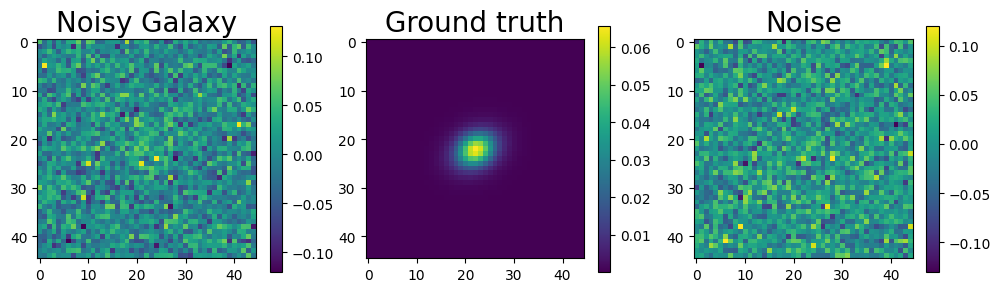

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

image_num = 40

im = axs[0].imshow(isolated_images[0][image_num][:, :, 2])
fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].set_title("Noisy Galaxy", fontsize=20)

im = axs[1].imshow(isolated_images[1][image_num][:, :, 2])
fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].set_title("Ground truth", fontsize=20)


difference = isolated_images[1][image_num][:, :, 2] - isolated_images[0][image_num][:, :, 2]
im = axs[2].imshow(difference)
fig.colorbar(im, ax=axs[2],shrink=0.8)
axs[2].set_title("Noise", fontsize=20)
plt.savefig("isolated_galaxy")

## Load trained models

In [7]:
from maddeb.utils import get_data_dir_path

data_dir = get_data_dir_path()

tf.get_logger().setLevel('ERROR')
latent_dim = 16
num_nf_layers = 8
model_path = os.path.join(data_dir, f"catsim_kl{3}{latent_dim}d/")

flow_net = FlowVAEnet(latent_dim=latent_dim, num_nf_layers=num_nf_layers)

flow_net.load_flow_weights(weights_path=os.path.join(model_path, f"flow{num_nf_layers}/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(model_path, "vae/val_loss"))

flow_net.vae_model.trainable=False
flow_net.flow_model.trainable=False

print(flow_net.vae_model.summary())
print(flow_net.flow_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 45, 45, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 152)               2710168   
_________________________________________________________________
latent_space (MultivariateNo ((None, 16), (None, 16))  0         
_________________________________________________________________
decoder (Functional)         (None, 45, 45, 6)         2473190   
Total params: 5,183,358
Trainable params: 0
Non-trainable params: 5,183,358
_________________________________________________________________
None
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLa

2023-08-23 12:11:50.244814: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Section 1: Test the VAE

### Section 1.1 reconstructions.
If the VAE is able to correctly reconstruct images, we can conclude that the decoder can be used as a generative model

In [8]:
tf.get_logger().setLevel('ERROR')
isolated_images = next(ds_isolated_val)
model_vae_output_isolated = flow_net.vae_model(isolated_images[0])
#model_vae_output_isolated = model_vae_output_isolated

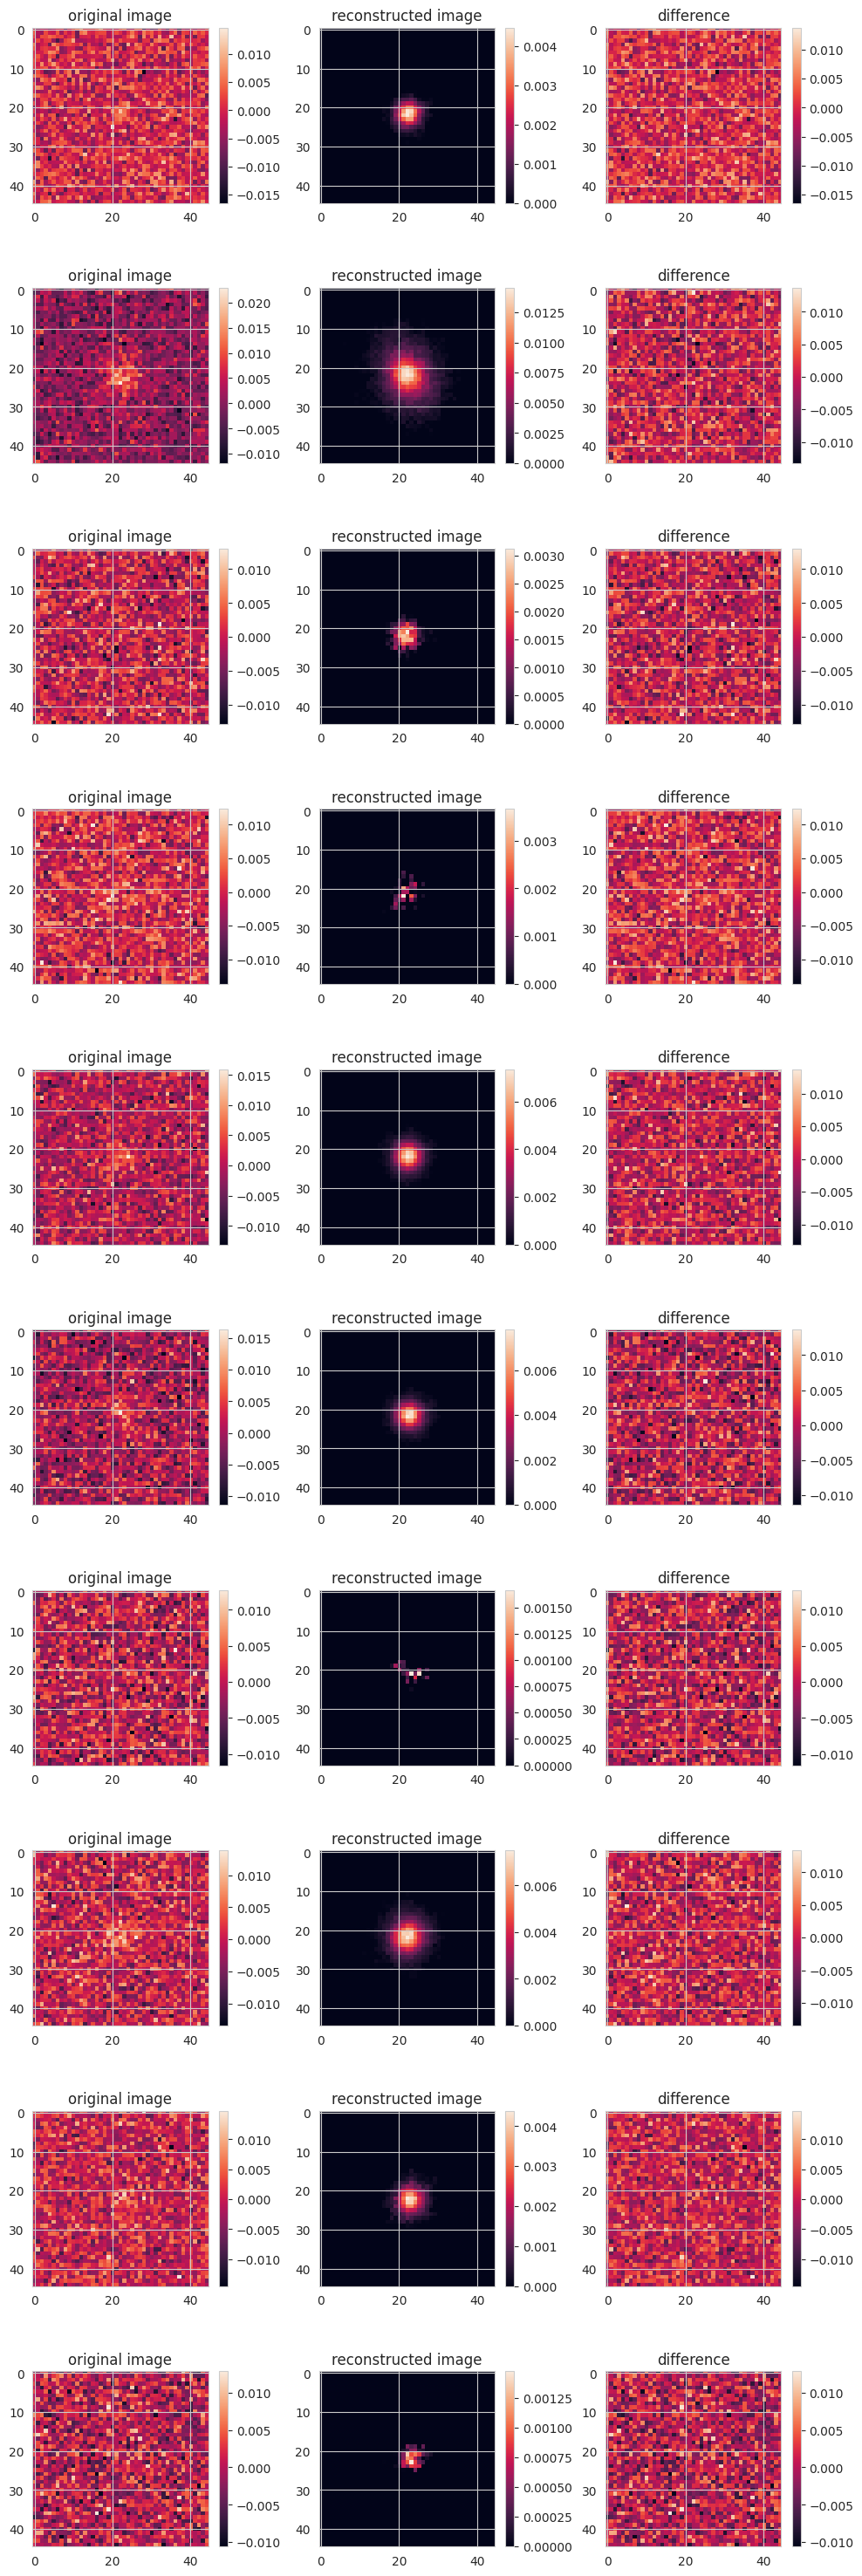

In [9]:
# sns.set_theme(style={"axes.grid": False,
#                      'axes.labelcolor': 'white',
#                      'figure.facecolor': '.15',
#                      'xtick.color': 'white',
#                      'ytick.color': 'white',
#                      'text.color': 'white',
#                      'image.cmap': 'viridis',})

sns.set_style("whitegrid")

fig, axs = plt.subplots(10, 3, figsize=(10,30))

for i in range(10):
    
    image_num = i + 20
    band_num = 0
    im = axs[i, 0].imshow(isolated_images[0][image_num][:, :, band_num])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(model_vae_output_isolated.numpy()[image_num][ :, :, band_num])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("reconstructed image")


    difference = isolated_images[0][image_num][:, :, band_num] - model_vae_output_isolated.numpy()[image_num][ :, :, band_num]
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

Conclusion: The reconstructions of galaxies work fairly well! <br>
So the decoder can be used as a generative model by sampling from the latent space.

### Section 1.2 Latent space distribution

In this section we aim to study the latent space distribution of galaxies as learnt by the VAE

In [10]:
import tensorflow_probability as tfp
z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(flow_net.encoder(isolated_images[0]))

In [57]:
latent_vars = []
for i in range(100):
    isolated_images_batch = next(ds_isolated_val)
    #images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))
    z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(flow_net.encoder(isolated_images_batch[0]))

    latent_vars.extend(list(z.sample().numpy()))
latent_vars = np.array(latent_vars)

In [58]:
print(latent_vars.shape)

(5000, 16)


In [59]:
latent_vars_list =[]
for i in range(latent_dim):
    latent_vars_list.append(latent_vars[:, i])

In [60]:
print(len(latent_vars_list))

16


Text(0, 0.5, 'distribution')

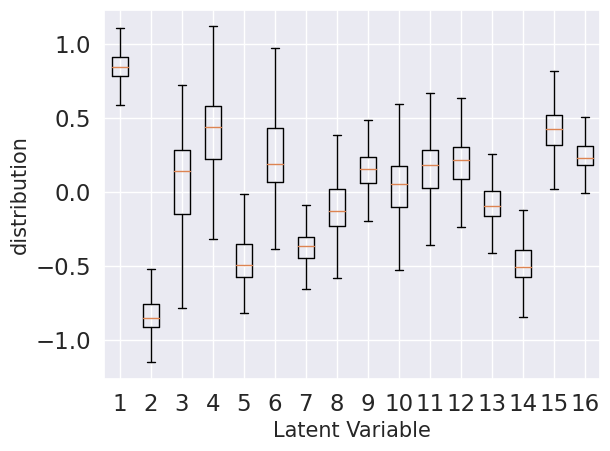

In [61]:
plt.boxplot(latent_vars_list, showfliers=False)
plt.xlabel("Latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

The plot shows the distribution of the latent space variables as learnt by the VAE. <br>
In the next section we will try to see if we can model this distribution using the Normalizing Flow network. 

# Section 2. Test the flow network

### Section 2.1 Likelihood distribution

In this section, we will test if the flow network assigns high probability to data it had seen trained on relative to unseen galaxies.

In [62]:
ds_blended_train, ds_blended_val = batched_CATSIMDataset(
    tf_dataset_dir='/sps/lsst/users/bbiswas/simulations/CATSIM_tfDataset/blended_tfDataset',
    linear_norm_coeff=linear_norm_coeff,
    batch_size=batch_size,
    x_col_name="blended_gal_stamps",
    y_col_name="isolated_gal_stamps",
)
ds_blended_val = ds_blended_val.as_numpy_iterator()

Load dataset info from /sps/lsst/users/bbiswas/simulations/CATSIM_tfDataset/blended_tfDataset/catsim_dataset/1.0.0
Reusing dataset catsim_dataset (/sps/lsst/users/bbiswas/simulations/CATSIM_tfDataset/blended_tfDataset/catsim_dataset/1.0.0)
Constructing tf.data.Dataset catsim_dataset for split None, from /sps/lsst/users/bbiswas/simulations/CATSIM_tfDataset/blended_tfDataset/catsim_dataset/1.0.0


In [63]:
blended_images = next(ds_blended_val)

In [64]:
isolated_likelihood = flow_net.flow_model(blended_images[1])
blended_likelihood = flow_net.flow_model(blended_images[0])

likelihood_difference=isolated_likelihood-blended_likelihood

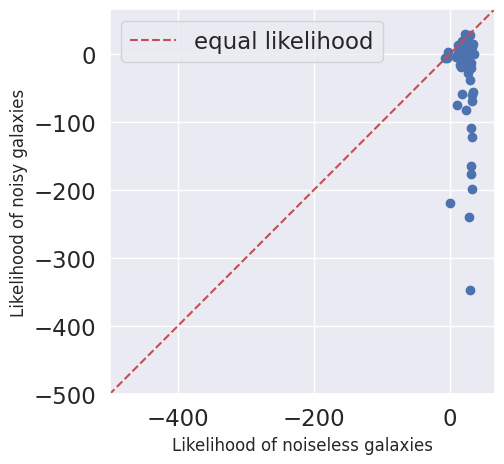

In [65]:
fig = plt.figure(figsize=(5,5))
plt.scatter(isolated_likelihood, blended_likelihood)
max_lim = max(np.amax(isolated_likelihood), np.amax(blended_likelihood))
min_lim = min(np.amin(isolated_likelihood), np.amin(blended_likelihood))
plt.xlim(-500, max_lim+30)
plt.ylim(-500, max_lim+30)
plt.plot((min_lim, max_lim+300), (min_lim, max_lim+300), ls="--", c="r", label="equal likelihood")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("Likelihood of noiseless galaxies", fontsize=12)
plt.ylabel("Likelihood of noisy galaxies", fontsize=12)
plt.legend()

we observe from the result here that the likelihood of noiseless galaxies is higher than that of blended/noisy ones.

In [66]:
#plt.hist(likelihood_difference.numpy(), bins=30);

### Section 2.2 Learnt latent space distribution

Finally, let's try to see the distribution of latent variables learnt by the normalizing flow:

In [67]:
sampled_latent_vars = flow_net.td.sample(len(latent_vars_list[0]), seed = 13).numpy()
sampled_latent_vars_list =[]
for i in range(latent_dim):
    sampled_latent_vars_list.append(sampled_latent_vars[:, i])

In [68]:
print(len(sampled_latent_vars))

5000


On comparing the sampled latent space distribution with the actual distribution, we see by eye that the flow nework is able to learn the complex distribution in the latent space.

In [69]:
latent_value=[]
latent_var_num=[]
latent_type=[]

for i in range(latent_dim):
    latent_value.extend(list(latent_vars_list[i]))
    latent_var_num.extend([i]*len(latent_vars_list[i]))
    latent_type.extend(["actual"]*len(latent_vars_list[i]))
    
    latent_value.extend(list(sampled_latent_vars_list[i]))
    latent_var_num.extend([i]*len(sampled_latent_vars_list[i]))
    latent_type.extend(["learnt"]*len(sampled_latent_vars_list[i]))
    
df_plot ={"latent_value": latent_value, "latent_var_num":latent_var_num, "latent_type":latent_type}

In [70]:
import pandas as pd
df_plot = pd.DataFrame(df_plot)

In [71]:
df_plot

,latent_value,latent_var_num,latent_type
0,0.855886,0,actual
1,0.755832,0,actual
2,0.756897,0,actual
3,0.682046,0,actual
4,0.773279,0,actual
...,...,...,...
159995,0.116440,15,learnt
159996,0.200161,15,learnt
159997,0.245830,15,learnt
159998,0.247296,15,learnt


Text(0, 0.5, 'distribution')

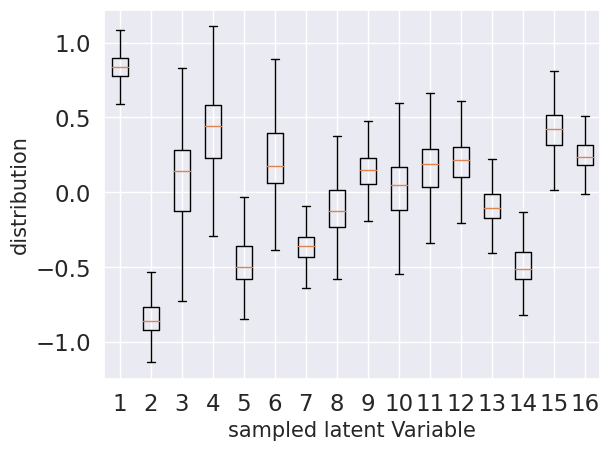

In [72]:
plt.boxplot(sampled_latent_vars_list, showfliers=False);
plt.xlabel("sampled latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

In [73]:
import seaborn as sns

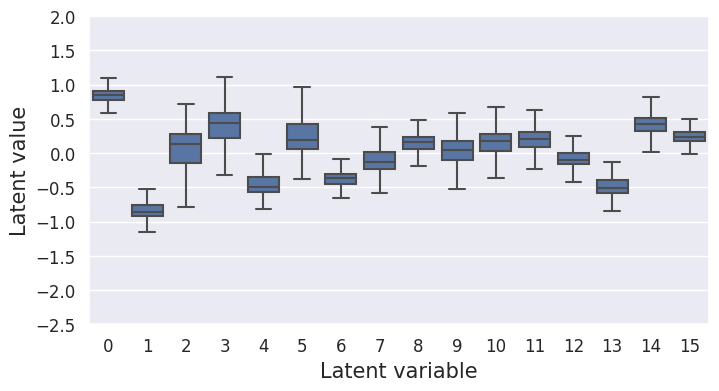

In [74]:
sns.set_theme(style={'text.color': 'black'})
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.boxplot(data=df_plot[df_plot["latent_type"]=="actual"], x="latent_var_num", y="latent_value", showfliers=False, color="b")
ax.set_ylim(-2.5,2,5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Latent variable", fontsize=15)
ax.set_ylabel("Latent value", fontsize=15)

plt.savefig("results/latent_boxplot")
plt.savefig("results/latent_boxplot.pdf", bbox_inches = 'tight')

In [75]:
np.shape(np.concatenate((latent_vars_list[0], sampled_latent_vars_list[0])))

(10000,)

In [76]:
latent_vars_list[0]

array([0.85588616, 0.7558325 , 0.75689703, ..., 2.9593296 , 0.90028155,
       0.48818463], dtype=float32)

In [77]:
latent_value=[]
latent_var_num=[]
latent_type=[]

df_sns = {}

for i in range(5):
    df_sns["Variable " + str(i + 1)] = np.concatenate((latent_vars_list[i], sampled_latent_vars_list[i]))

df_sns["latent type"] = ["actual distribution"]*len(latent_vars_list[i]) + ["learnt distribution"]*len(sampled_latent_vars_list[i])
df_sns = pd.DataFrame(df_sns)

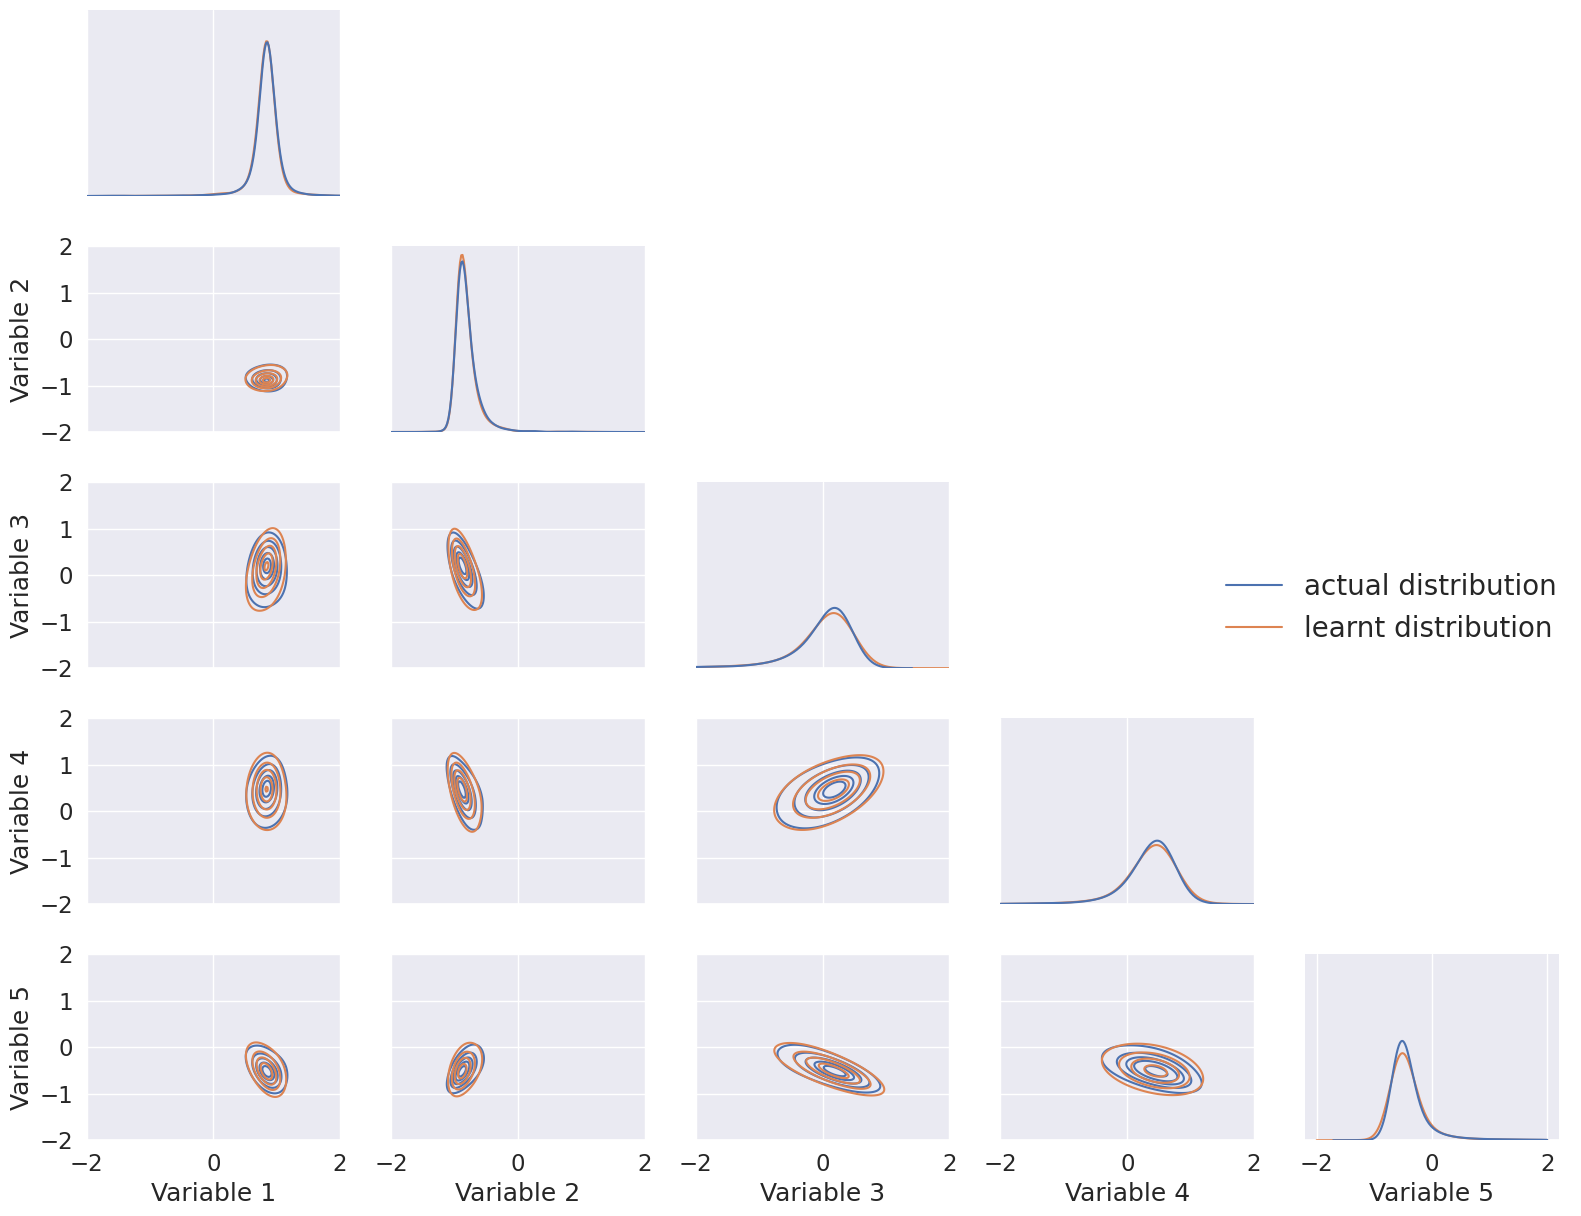

In [79]:
sns.set(font_scale=1.5)

g = sns.PairGrid(df_sns, hue="latent type", corner=True)

g.map_lower(sns.kdeplot, clip=[-2, 2], levels=[.2, .4, .6, .8, .95])
g.map_diag(sns.kdeplot, clip=[-2, 2])

g.add_legend(fontsize=20, title="")
plt.tight_layout()

plt.savefig("results/latent_distribution_correlation")
plt.savefig("results/latent_distribution_correlation.pdf", bbox_inches = 'tight')

# Test VAE as deblender

In [33]:
flow_net.load_vae_weights(weights_path=os.path.join(model_path, "deblender/val_loss"))

In [34]:
tf.get_logger().setLevel('ERROR')
deblended_output_isolated = flow_net.vae_model(blended_images[0])

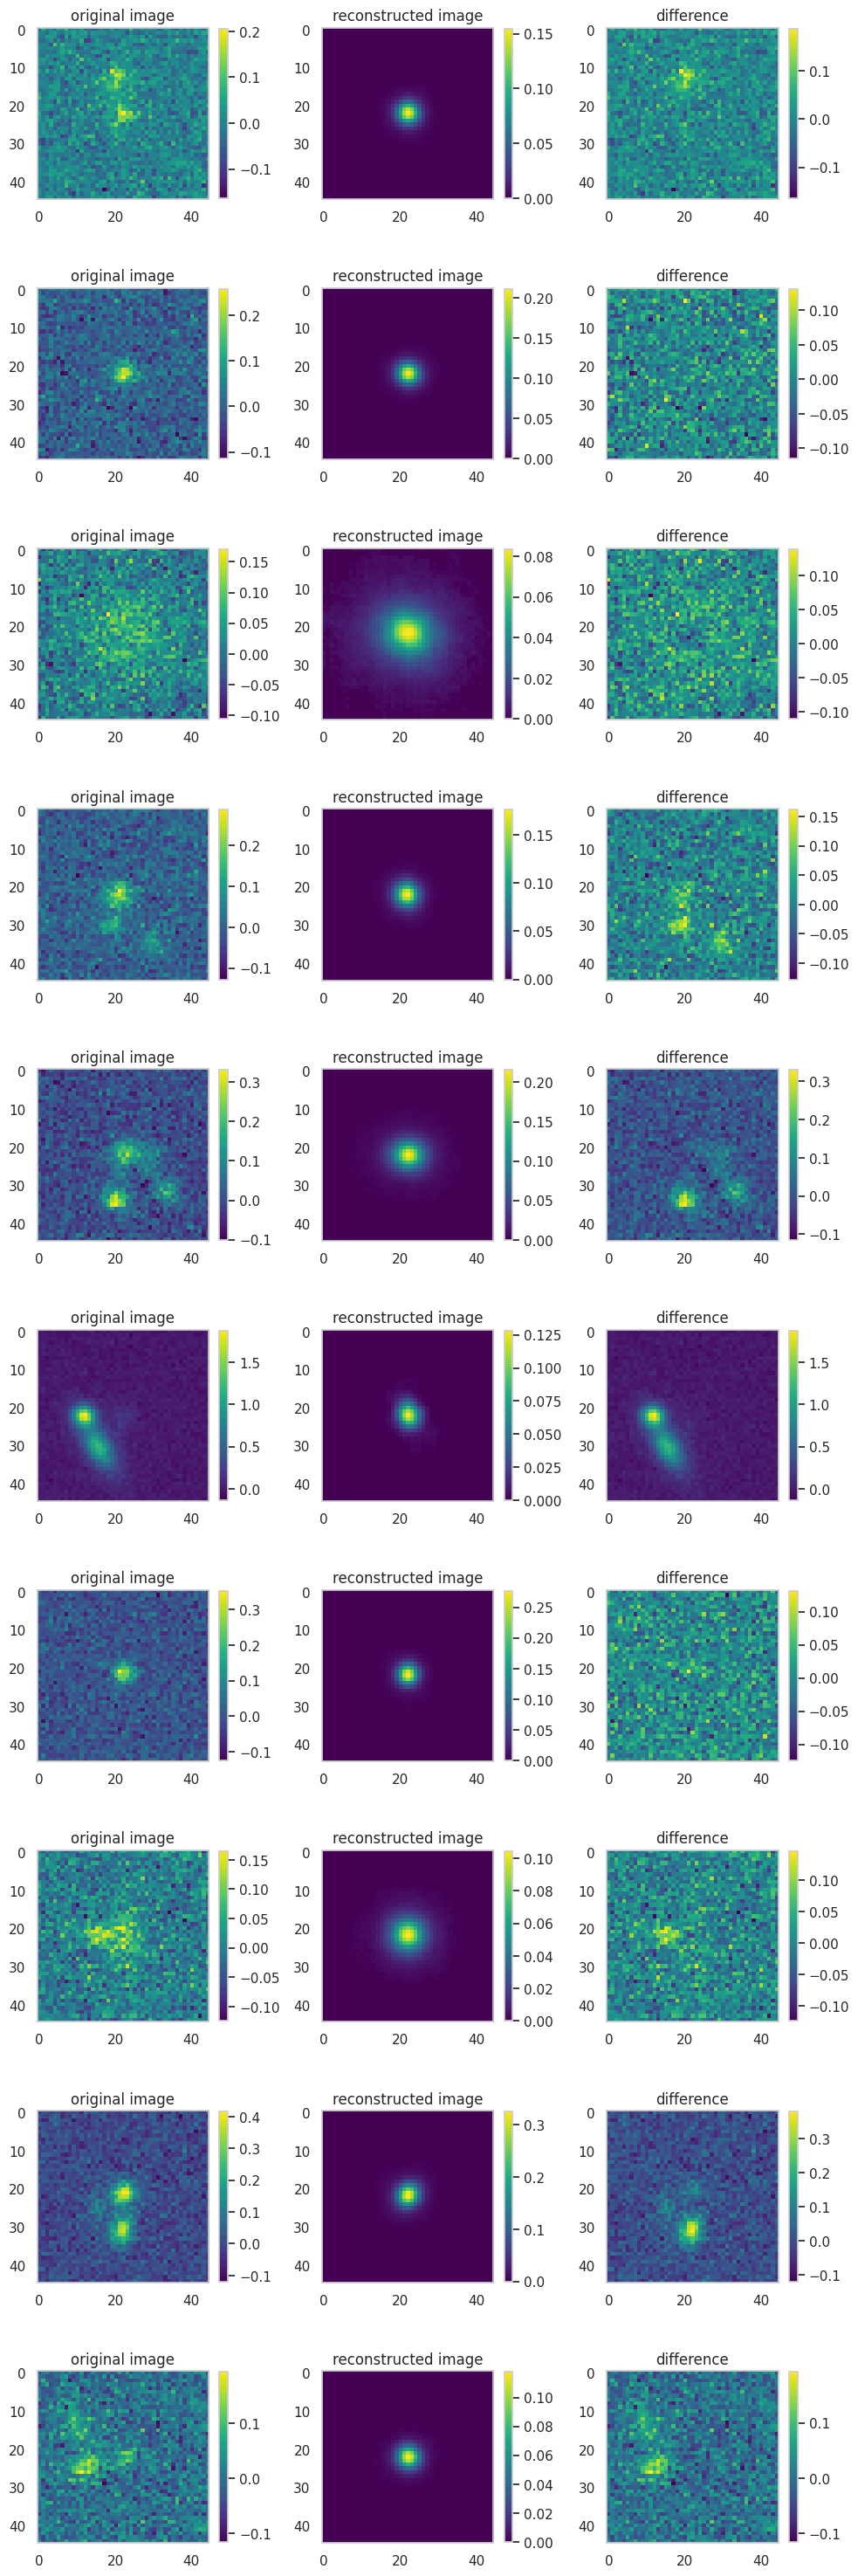

In [35]:
# sns.set_theme(style={"axes.grid": False,
#                      'axes.labelcolor': 'white',
#                      'figure.facecolor': '.15',
#                      'xtick.color': 'white',
#                      'ytick.color': 'white',
#                      'text.color': 'white',
#                      'image.cmap': 'viridis',})

sns.set_style("whitegrid")
sns.set_theme(style={"axes.grid": False,
                     'image.cmap': 'viridis',})
fig, axs = plt.subplots(10, 3, figsize=(10,30))

for i in range(10):
    
    image_num = i+40
    band_num = 2
    im = axs[i, 0].imshow(blended_images[0][image_num][:, :, band_num])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(deblended_output_isolated.numpy()[image_num][ :, :, band_num])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("reconstructed image")


    difference = blended_images[0][image_num][:, :, band_num] - deblended_output_isolated.numpy()[image_num][ :, :, band_num]
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

##### 

In [ ]:
image_num = 30
im = plt.imshow(images_blended_normed[image_num][:, :, 2]);
ax=plt.gca()
plt.colorbar(im, ax=ax)

In [ ]:
flipped = np.flip(images_blended_normed, axis=1)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)

In [ ]:
flipped = np.flip(images_blended_normed, axis=2)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)

In [ ]:
flipped = np.flip(np.flip(images_blended_normed, axis=1), axis=2)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)